In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Team-AY/FER-NN-DAN
import os
os.chdir('/content/FER-NN-DAN')

!pwd

Cloning into 'FER-NN-DAN'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 154 (delta 57), reused 68 (delta 43), pack-reused 64 (from 1)
Receiving objects: 100% (154/154), 6.91 MiB | 11.11 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/FER-NN-DAN


<h1>Results Script</h1>

In [3]:
# for the code run faster we move the dataset to this folder and then unzip it.
!mkdir /content/FER-NN-DAN/data
!unzip /content/drive/MyDrive/Final_Project/Databases/fer-2013.zip  -d /content/FER-NN-DAN/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/FER-NN-DAN/data/images/Training_84431642.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84431790.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84435400.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84437455.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84441308.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84448524.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84449951.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84449989.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84450422.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84458220.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_8446503.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_8447007.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_84471953.jpg  
  inflating: /content/FER-NN-DAN/data/images/Training_

In [4]:
import sys
sys.path.append('/content/FER-NN-DAN')  # Replace with your actual path

In [5]:
#import libraries and setup
import torch
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from PIL import Image
from networks.dan import DAN
from fer2013train import RafDataSet
import os

%matplotlib inline

<h3>Functions Definitions</h3>

In [6]:
def load_data(path, bs, workers, normalize):

      val_dataset = RafDataSet(path, phase = 'test', transform = normalize)

      val_loader = torch.utils.data.DataLoader(val_dataset,
                                                  batch_size = bs,
                                                  num_workers = workers,
                                                  shuffle = False,
                                                  pin_memory = True)
      return val_loader

In [18]:
def evaluate_model(model, test_loader , device):
    all_preds = []
    all_labels = []

    model = model[0].eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:  # Loop through batches
            predictions, *_ = model(images)
            _, predicted_labels = torch.max(predictions, 1)

            all_preds.extend(predicted_labels.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store actual labels

    accuracy = accuracy_score(all_labels, all_preds)
    conf_mat = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    return accuracy, conf_mat, class_report

In [8]:
def load_model(checkpoint_path, model):
    """""
    Args: checkpoint_path (str): Path to the checkpoint file.

    Returns: torch.nn.Module: Loaded model.
    """""
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [9]:
def loop_func(model_checkpoints,path,val_loader, device):

  model_names = []
  accuracies = []
  conf_mats = []
  class_reports = []

  model = DAN(num_head=4, num_class=7, pretrained=False)
  # Loop through each model checkpoint, load the model and evaluate
  for checkpoint in model_checkpoints:
      print(f"Evaluating model: {checkpoint}")
      checkpoint_path = os.path.join(path, checkpoint)
      loaded_model = load_model(checkpoint_path,model)
      accuracy, conf_mat, class_report = evaluate_model([loaded_model], val_loader,device)

      model_names.append(checkpoint)
      accuracies.append(accuracy)
      conf_mats.append(conf_mat)
      class_reports.append(class_report)

  return model_names, accuracies, conf_mats, class_reports

In [10]:
#main
from types import SimpleNamespace

data_transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])



DAN_path= '/content/drive/MyDrive/Final_Project/Models_cheackpoints/DAN'
model_checkpoints = ['DAN-batch-256.pth','DAN-batch-128.pth','DAN-batch-64.pth']


# Define the paths in a dictionary
args_dict = {
    "fer2013_path": "/content/FER-NN-DAN/data",
    "label_path": "/content/FER-NN-DAN/data/EmoLabel/ferEmoLabellist.txt"
}

# Convert the dictionary to a namespace object
args = SimpleNamespace(**args_dict)
val_loader = load_data(args.fer2013_path, 128, 4, data_transforms_val)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
model_names, accuracies, conf_mats, class_reports = loop_func(model_checkpoints,DAN_path,val_loader, device)

Evaluating model: DAN-batch-256.pth
Evaluating model: DAN-batch-128.pth
Evaluating model: DAN-batch-64.pth


In [20]:
import json


# Create a dictionary to hold all the data
raf_results = {
    'model_names': model_names,
    'accuracies': accuracies,
    'confusion_matrices': [cm.tolist() for cm in conf_mats], # Convert to list
    'classification_reports': [cr for cr in class_reports] # Assuming it's serializable
}

# Save to JSON file
with open('DAN_model_results.json', 'w') as f:
    json.dump(raf_results, f)

print('Confusion matrices and classification reports saved to DAN_model_results.json')


Confusion matrices and classification reports saved to DAN_model_results.json


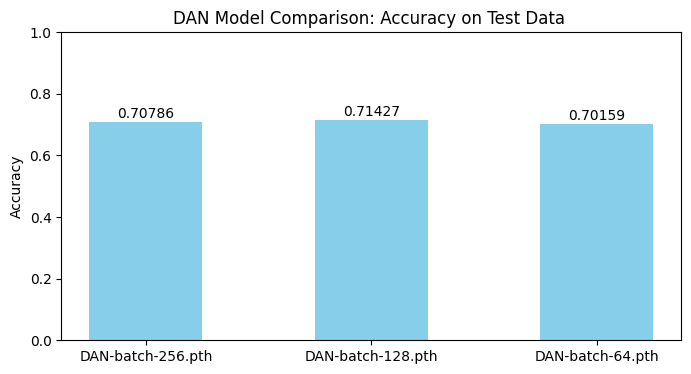

In [21]:
# 1. Plot model accuracies for comparison
plt.figure(figsize=(8, 4))
plt.bar(model_names, accuracies, color='skyblue',  width=0.5)
plt.ylim(0, 1)

for i, (model_name, accuracy) in enumerate(zip(model_names, accuracies)):
  x_pos = i  # Adjust x position if needed (e.g., for center alignment)
  y_pos = accuracy + 0.005  # Adjust y position for some space above the bar

  plt.text(x_pos, y_pos, f"{accuracy:.5f}", ha='center', va='bottom')  # Format and align the label

  plt.ylabel('Accuracy')
  plt.title('DAN Model Comparison: Accuracy on Test Data ')

plt.savefig(f'DAN Model Comparison: Accuracy on Test Data')
plt.show()

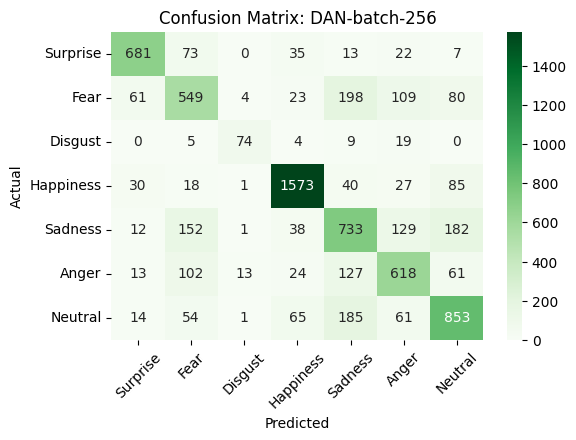

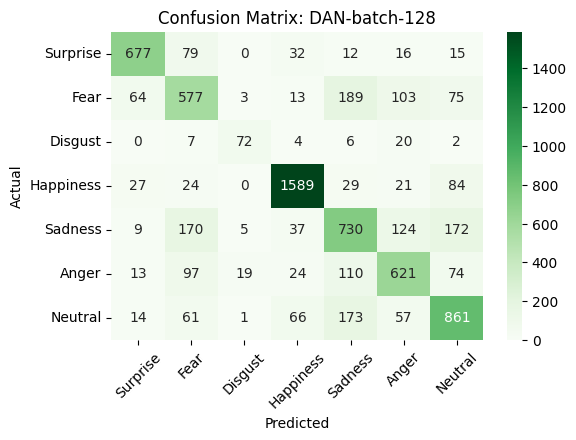

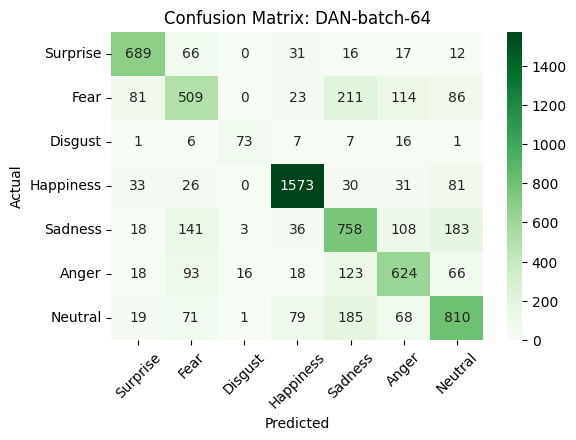

In [22]:
# 2. Plot Confusion Matrices
labels = ['Surprise' ,'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
for i, conf_mat in enumerate(conf_mats):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    txt = model_names[i].split(".")
    plt.title(f'Confusion Matrix: {txt[0]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.savefig(f'Confusion Matrix fernorm: {txt[0]}')
    plt.show()

In [23]:
print("DAN model class reports")
# 3. Print Classification Reports for each model
for i, class_report in enumerate(class_reports):

    class_report_df = pd.DataFrame(class_report).transpose()
    new_labels = labels
    class_report_df.index = new_labels + ['accuracy', 'macro avg', 'weighted avg']
    print("")
    print("")
    print("----------------------------------------------------")
    txt = model_names[i].split(".")
    print(f'Classification Report: {txt[0]}')
    print(class_report_df)

DAN model class reports


----------------------------------------------------
Classification Report: DAN-batch-256
              precision    recall  f1-score      support
Surprise       0.839704  0.819495  0.829476   831.000000
Fear           0.576076  0.536133  0.555387  1024.000000
Disgust        0.787234  0.666667  0.721951   111.000000
Happiness      0.892736  0.886697  0.889706  1774.000000
Sadness        0.561686  0.587811  0.574451  1247.000000
Anger          0.627411  0.645094  0.636130   958.000000
Neutral        0.672713  0.691809  0.682127  1233.000000
accuracy       0.707857  0.707857  0.707857     0.707857
macro avg      0.708223  0.690529  0.698461  7178.000000
weighted avg   0.709073  0.707857  0.708178  7178.000000


----------------------------------------------------
Classification Report: DAN-batch-128
              precision    recall  f1-score      support
Surprise       0.842040  0.814681  0.828135   831.000000
Fear           0.568473  0.563477  0.565964  1024.0